<a href="https://colab.research.google.com/github/ywchanna2001/CM4150-RS_Project/blob/main/Recommender_System_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & Definition

# --- STEP 1: PROBLEM DEFINITION ---

Domain: Movie Recommendations (MovieLens 100k Dataset)

Users: Movie viewers who have rated at least 20 movies.

Items: Movies with metadata (genres).

Objective: Top-N Recommendation. We want to recommend a personalized list of 10 unseen movies to users.

Algorithm: Weighted Hybrid Recommender (SciPy SVD Collaborative Filtering + TF-IDF Content-Based Filtering).

Bonus Features Included: Hybrid Approach, Cold-Start Handling (Fallback to Popularity).


In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as sk_train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from collections import defaultdict
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully using default Colab environment!")

Libraries imported successfully using default Colab environment!


# Data Analysis and Preprocessing

In [8]:
# --- STEP 2: DATASET PREPARATION & ANALYSIS ---
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

print("=========================================")
print("      DATASET CLEANING & INSPECTION      ")
print("=========================================")
# Check for missing values
print("Missing values in Ratings Data:")
print(ratings.isnull().sum())
print("\nMissing values in Movies Data:")
print(movies.isnull().sum())

# Drop duplicates just in case
ratings.drop_duplicates(inplace=True)

print("\n=========================================")
print("          DATASET STATISTICS             ")
print("=========================================")
# 2. Dataset Analysis & Sparsity Calculation
num_users = ratings['userId'].nunique()
num_movies = ratings['movieId'].nunique()
num_interactions = len(ratings)
sparsity = 1.0 - (num_interactions / (num_users * num_movies))

print(f"Total Users: {num_users}")
print(f"Total Movies: {num_movies}")
print(f"Total Interactions (Ratings): {num_interactions}")
print(f"Dataset Sparsity: {sparsity * 100:.4f}%")

# 3. User & Item Behavior Analysis
user_activity = ratings.groupby('userId')['rating'].count()
movie_popularity = ratings.groupby('movieId')['rating'].count()

print(f"\nAverage ratings per user: {user_activity.mean():.0f} (Min: {user_activity.min()}, Max: {user_activity.max()})")
print(f"Average ratings per movie: {movie_popularity.mean():.0f} (Min: {movie_popularity.min()}, Max: {movie_popularity.max()})")

      DATASET CLEANING & INSPECTION      
Missing values in Ratings Data:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Missing values in Movies Data:
movieId    0
title      0
genres     0
dtype: int64

          DATASET STATISTICS             
Total Users: 610
Total Movies: 9724
Total Interactions (Ratings): 100836
Dataset Sparsity: 98.3000%

Average ratings per user: 165 (Min: 20, Max: 2698)
Average ratings per movie: 10 (Min: 1, Max: 329)


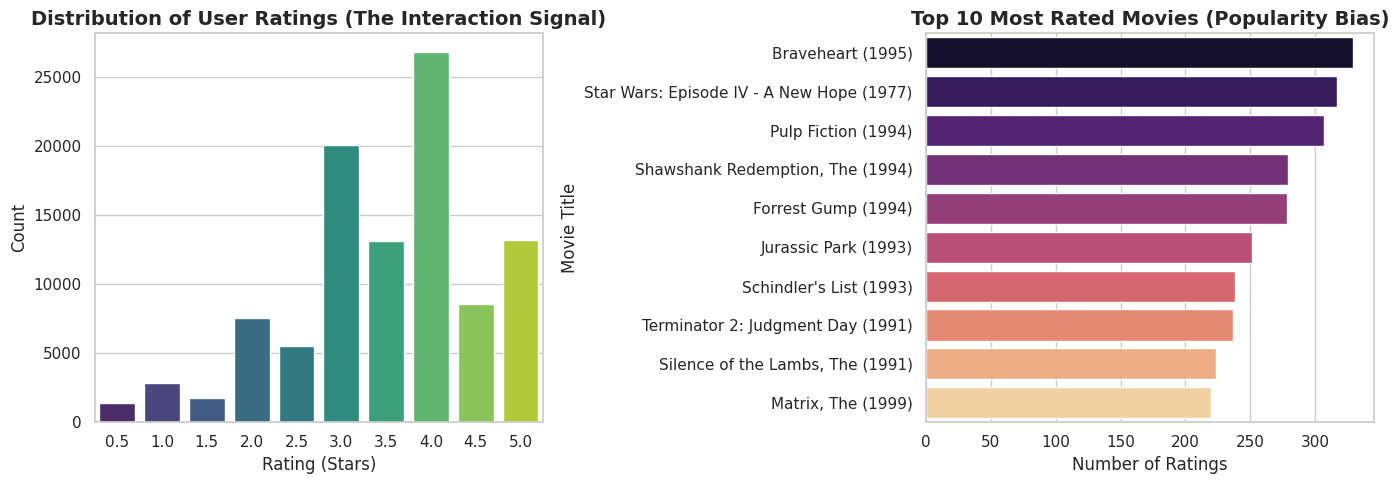

             DATA SPLITTING              
Training interactions (80%): 80668
Testing interactions (20%): 20168


In [9]:
# 4. Data Visualizations
sns.set_theme(style="whitegrid")
plt.figure(figsize=(14, 5))

# Plot 1: Rating Distribution
plt.subplot(1, 2, 1)
sns.countplot(x='rating', data=ratings, palette='viridis')
plt.title('Distribution of User Ratings (The Interaction Signal)', fontsize=14, fontweight='bold')
plt.xlabel('Rating (Stars)')
plt.ylabel('Count')

# Plot 2: Top 10 Most Rated Movies (Popularity Bias / Long-Tail)
plt.subplot(1, 2, 2)
top_movies_idx = movie_popularity.nlargest(10).index
top_movie_titles = movies[movies['movieId'].isin(top_movies_idx)]['title'].tolist()
sns.barplot(x=movie_popularity.nlargest(10).values, y=top_movie_titles, palette='magma')
plt.title('Top 10 Most Rated Movies (Popularity Bias)', fontsize=14, fontweight='bold')
plt.xlabel('Number of Ratings')
plt.ylabel('Movie Title')

plt.tight_layout()
plt.show()

# 5. Feature Preprocessing (Content-Based)
# Replace '|' with spaces in genres for TF-IDF to process them as text tokens
movies['genres'] = movies['genres'].str.replace('|', ' ', regex=False)

# Mappings for fast lookups later in the algorithm
movie_to_idx = {movie_id: idx for idx, movie_id in enumerate(movies['movieId'])}
movie_id_to_title = dict(zip(movies['movieId'], movies['title']))

# 6. Train/Test Split (80/20)
train_df, test_df = sk_train_test_split(ratings, test_size=0.2, random_state=42)
print("=========================================")
print("             DATA SPLITTING              ")
print("=========================================")
print(f"Training interactions (80%): {len(train_df)}")
print(f"Testing interactions (20%): {len(test_df)}")

#  Model Development (Baseline + Content + SciPy SVD + Hybrid)

In [3]:
# --- STEP 3: MODEL DEVELOPMENT ---
global_mean = train_df['rating'].mean()

# ---------------------------------------------------------
# A. BASELINE MODEL: Most Popular
# ---------------------------------------------------------
movie_stats = train_df.groupby('movieId')['rating'].agg(['count', 'mean'])
movie_stats['pop_score'] = movie_stats['mean'] * np.log1p(movie_stats['count'])
max_pop, min_pop = movie_stats['pop_score'].max(), movie_stats['pop_score'].min()
movie_stats['pop_score_norm'] = 0.5 + 4.5 * ((movie_stats['pop_score'] - min_pop) / (max_pop - min_pop))
popularity_dict = movie_stats['pop_score_norm'].to_dict()

def predict_baseline(iid):
    return popularity_dict.get(iid, global_mean)

# ---------------------------------------------------------
# B. CONTENT-BASED FILTERING (TF-IDF + Cosine Similarity)
# ---------------------------------------------------------
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['genres'])
cosine_sim_matrix = cosine_similarity(tfidf_matrix, tfidf_matrix)

train_user_ratings = train_df.groupby('userId').apply(lambda x: dict(zip(x.movieId, x.rating))).to_dict()

def predict_cbf(uid, iid):
    if uid not in train_user_ratings or iid not in movie_to_idx:
        return predict_baseline(iid)

    user_history = train_user_ratings[uid]
    target_idx = movie_to_idx[iid]

    sim_scores = []
    for rated_iid, rating in user_history.items():
        if rated_iid in movie_to_idx:
            rated_idx = movie_to_idx[rated_iid]
            sim = cosine_sim_matrix[target_idx, rated_idx]
            sim_scores.append((sim, rating))

    num = sum(sim * r for sim, r in sim_scores if sim > 0)
    den = sum(sim for sim, r in sim_scores if sim > 0)
    return num / den if den > 0 else predict_baseline(iid)

# ---------------------------------------------------------
# C. COLLABORATIVE FILTERING (Matrix Factorization via SciPy SVD)
# ---------------------------------------------------------
# 1. Create User-Item Matrix
user_item_matrix = train_df.pivot(index='userId', columns='movieId', values='rating')
user_ids = user_item_matrix.index
movie_ids = user_item_matrix.columns

# 2. Normalize by subtracting user mean (to handle missing values effectively)
user_ratings_mean = user_item_matrix.mean(axis=1)
R_demeaned = user_item_matrix.sub(user_ratings_mean, axis=0).fillna(0).to_numpy()

# 3. Perform SVD (Singular Value Decomposition)
k = 50 # Number of latent factors
U, sigma, Vt = svds(R_demeaned, k=k)
sigma = np.diag(sigma)

# 4. Reconstruct Matrix and add means back
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) + user_ratings_mean.values.reshape(-1, 1)

# 5. Store in DataFrame for quick lookups
cf_preds_df = pd.DataFrame(all_user_predicted_ratings, columns=movie_ids, index=user_ids)

def predict_cf(uid, iid):
    # Retrieve SVD prediction, or fallback to baseline if user/item was not in training set
    if uid in cf_preds_df.index and iid in cf_preds_df.columns:
        return cf_preds_df.loc[uid, iid]
    return predict_baseline(iid)

# ---------------------------------------------------------
# D. HYBRID MODEL (Weighted CF + CBF)
# ---------------------------------------------------------
def predict_hybrid(uid, iid, alpha=0.6):
    cf_score = predict_cf(uid, iid)
    cbf_score = predict_cbf(uid, iid)
    return (alpha * cf_score) + ((1 - alpha) * cbf_score)

print("Baseline, Content-Based, SVD Matrix Factorization, and Hybrid Models trained successfully!")

Baseline, Content-Based, SVD Matrix Factorization, and Hybrid Models trained successfully!


# DEEP NEURAL NETWORK (Neural Collaborative Filtering)

In [4]:
# ---------------------------------------------------------
# E. ADVANCED DEEP NEURAL NETWORK (Neural Collaborative Filtering)
# ---------------------------------------------------------

print("Building and Training Advanced Deep Neural Network...")

# 1. Map User IDs to contiguous integers (0 to N-1) for Keras Embeddings
unique_users = ratings['userId'].unique()
user_to_idx = {user_id: idx for idx, user_id in enumerate(unique_users)}
num_users_dnn = len(unique_users)
num_movies_dnn = len(movies)

# 2. Prepare Training Data for Neural Network
X_train_user = np.array([user_to_idx[u] for u in train_df['userId']])
X_train_movie = np.array([movie_to_idx[m] for m in train_df['movieId']])
y_train = train_df['rating'].values

# 3. Define the Advanced Neural Network Architecture
latent_dim = 32

# Inputs
user_input = Input(shape=(1,), name='user_input')
movie_input = Input(shape=(1,), name='movie_input')

# Embedding Layers with L2 Regularization (Prevents overfitting)
user_embedding = Embedding(input_dim=num_users_dnn, output_dim=latent_dim,
                           embeddings_regularizer=l2(1e-6), name='user_embedding')(user_input)
movie_embedding = Embedding(input_dim=num_movies_dnn, output_dim=latent_dim,
                            embeddings_regularizer=l2(1e-6), name='movie_embedding')(movie_input)

# Flatten
user_vec = Flatten(name='flatten_users')(user_embedding)
movie_vec = Flatten(name='flatten_movies')(movie_embedding)

# Concatenate
concat = Concatenate(name='concat')([user_vec, movie_vec])

# Multi-Layer Perceptron with Batch Normalization and Dropout
dense_1 = Dense(128, activation='relu')(concat)
bn_1 = BatchNormalization()(dense_1)
drop_1 = Dropout(0.3)(bn_1)

dense_2 = Dense(64, activation='relu')(drop_1)
bn_2 = BatchNormalization()(dense_2)
drop_2 = Dropout(0.2)(bn_2)

dense_3 = Dense(32, activation='relu')(drop_2)

# Output Layer
output = Dense(1, activation='linear', name='output')(dense_3)

# 4. Compile Model
dnn_model = Model(inputs=[user_input, movie_input], outputs=output)
dnn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

# 5. Advanced Callbacks
# Stops training if val_loss doesn't improve for 3 epochs, and restores the best model weights
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True, verbose=1)
# Reduces learning rate by half if val_loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

# 6. Train the Model (Set to 50 epochs, but Early Stopping will likely halt it around epoch 10-20)
print("Training started. Early stopping is enabled...")
history = dnn_model.fit(
    [X_train_user, X_train_movie], y_train,
    batch_size=256,
    epochs=50,
    verbose=1,
    validation_split=0.1,
    callbacks=[early_stopping, reduce_lr]
)

# 7. Prediction Functions
def predict_dnn_single(uid, iid):
    """For predicting a single movie (Used in Step 5: Demonstration)"""
    if uid not in user_to_idx or iid not in movie_to_idx:
        return predict_baseline(iid) # Cold Start
    u_idx = np.array([user_to_idx[uid]])
    m_idx = np.array([movie_to_idx[iid]])
    pred = dnn_model.predict([u_idx, m_idx], verbose=0)[0][0]
    return np.clip(pred, 0.5, 5.0)

def precompute_dnn_for_test(test_dataframe):
    """Batch prediction for the test set (Speeds up Step 4 Evaluation massively)"""
    print("Batch predicting DNN scores for evaluation...")
    u_indices, m_indices, valid_mask = [], [], []

    # Check for cold starts
    for _, row in test_dataframe.iterrows():
        uid, iid = row['userId'], row['movieId']
        is_known = uid in user_to_idx and iid in movie_to_idx
        valid_mask.append(is_known)
        u_indices.append(user_to_idx.get(uid, 0)) # Default to 0, will be overwritten if cold start
        m_indices.append(movie_to_idx.get(iid, 0))

    # Batch predict all at once
    raw_preds = dnn_model.predict([np.array(u_indices), np.array(m_indices)], batch_size=1024, verbose=0).flatten()

    # Build dictionary map
    dnn_preds_dict = {}
    for i, (_, row) in enumerate(test_dataframe.iterrows()):
        uid, iid = row['userId'], row['movieId']
        if valid_mask[i]:
            dnn_preds_dict[(uid, iid)] = np.clip(raw_preds[i], 0.5, 5.0)
        else:
            dnn_preds_dict[(uid, iid)] = predict_baseline(iid)

    return dnn_preds_dict

print("\nAdvanced Deep Neural Network trained successfully!")

Building and Training Advanced Deep Neural Network...
Training started. Early stopping is enabled...
Epoch 1/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 7.5849 - val_loss: 1.1188 - learning_rate: 0.0010
Epoch 2/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0604 - val_loss: 0.8888 - learning_rate: 0.0010
Epoch 3/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.8933 - val_loss: 0.8305 - learning_rate: 0.0010
Epoch 4/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8112 - val_loss: 0.8223 - learning_rate: 0.0010
Epoch 5/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7481 - val_loss: 0.8141 - learning_rate: 0.0010
Epoch 6/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7110 - val_loss: 0.8059 - learning_rate: 0.0010
Epoch 7/50
284/284 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6786 - val_loss: 0.8095 - learning_rate: 0.0010
Epoch 8/50
281/284 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6461
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.00050

# Evaluation

In [5]:
# --- STEP 4: EVALUATION ---
def get_top_n_metrics(predictions, k=10, threshold=3.5):
    user_est_true = defaultdict(list)
    for uid, true_r, est in predictions:
        user_est_true[uid].append((est, true_r))

    precisions, recalls, hit_rates = dict(), dict(), dict()

    for uid, user_ratings in user_est_true.items():
        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0
        hit_rates[uid] = 1 if n_rel_and_rec_k > 0 else 0

    return (sum(precisions.values()) / len(precisions),
            sum(recalls.values()) / len(recalls),
            sum(hit_rates.values()) / len(hit_rates))

# Generate predictions arrays
preds_base, preds_cf, preds_hyb, preds_dnn = [], [], [], []

print("Evaluating Models... (This takes a few seconds)")

# Precompute DNN predictions in one massive batch for speed
# (This utilizes the precompute_dnn_for_test function we defined in Step 3)
dnn_test_predictions = precompute_dnn_for_test(test_df)

for _, row in test_df.iterrows():
    uid, iid, true_r = row['userId'], row['movieId'], row['rating']

    # 1. Baseline Prediction
    preds_base.append((uid, true_r, predict_baseline(iid)))

    # 2. Collaborative (SVD) Prediction
    preds_cf.append((uid, true_r, predict_cf(uid, iid)))

    # 3. Hybrid Prediction
    preds_hyb.append((uid, true_r, predict_hybrid(uid, iid)))

    # 4. Deep Neural Network Prediction (Using the fast dictionary)
    preds_dnn.append((uid, true_r, dnn_test_predictions[(uid, iid)]))

# Calculate Metrics for all 4 models
p_base, r_base, hr_base = get_top_n_metrics(preds_base)
p_cf, r_cf, hr_cf = get_top_n_metrics(preds_cf)
p_hyb, r_hyb, hr_hyb = get_top_n_metrics(preds_hyb)
p_dnn, r_dnn, hr_dnn = get_top_n_metrics(preds_dnn)

# Display Comparison Table
results = pd.DataFrame({
    'Metric': ['Precision@10', 'Recall@10', 'Hit Rate@10'],
    'Most Popular (Baseline)': [p_base, r_base, hr_base],
    'SVD (Collaborative)': [p_cf, r_cf, hr_cf],
    'Hybrid (SVD + CBF)': [p_hyb, r_hyb, hr_hyb],
    'Deep Neural Net (AI)': [p_dnn, r_dnn, hr_dnn]
})

print("\n--- PERFORMANCE COMPARISON TABLE ---")
display(results.round(4))

Evaluating Models... (This takes a few seconds)
Batch predicting DNN scores for evaluation...

--- PERFORMANCE COMPARISON TABLE ---


,Metric,Most Popular (Baseline),SVD (Collaborative),Hybrid (SVD + CBF),Deep Neural Net (AI)
0,Precision@10,0.7028,0.6574,0.6764,0.7313
1,Recall@10,0.3025,0.4721,0.4738,0.5288
2,Hit Rate@10,0.8705,0.8213,0.8180,0.9230


# Demonstration

In [6]:
# --- STEP 5: DEMONSTRATION ---
import numpy as np

def recommend_top_n_hybrid(user_id, n=10):
    """Generates Top-N recommendations using the Weighted Hybrid Model"""
    user_rated_movies = train_df[train_df['userId'] == user_id]['movieId'].tolist()
    all_movies = movies['movieId'].tolist()
    unrated_movies = [m for m in all_movies if m not in user_rated_movies]

    predictions = [(iid, predict_hybrid(user_id, iid)) for iid in unrated_movies]
    predictions.sort(key=lambda x: x[1], reverse=True)

    return [movie_id_to_title.get(iid, "Unknown") for iid, score in predictions[:n]]

def recommend_top_n_dnn(user_id, n=10):
    """Generates Top-N recommendations using the Deep Neural Network (Optimized for Speed)"""
    user_rated_movies = train_df[train_df['userId'] == user_id]['movieId'].tolist()
    all_movies = movies['movieId'].tolist()
    unrated_movies = [m for m in all_movies if m not in user_rated_movies]

    # Check for cold start
    if user_id not in user_to_idx:
        return [movie_id_to_title.get(iid, "Unknown") for iid in unrated_movies[:n]]

    u_idx = user_to_idx[user_id]
    m_indices = [movie_to_idx.get(m, 0) for m in unrated_movies]

    # Fast batch prediction
    user_array = np.full(len(m_indices), u_idx)
    movie_array = np.array(m_indices)

    preds = dnn_model.predict([user_array, movie_array], batch_size=1024, verbose=0).flatten()

    predictions = [(unrated_movies[i], preds[i]) for i in range(len(unrated_movies))]
    predictions.sort(key=lambda x: x[1], reverse=True)

    return [movie_id_to_title.get(iid, "Unknown") for iid, score in predictions[:n]]

# Select 3 distinct users for demonstration
demo_users = [10, 50, 120]

print("Generating Live Recommendations...\n")

for uid in demo_users:
    print("=======================================================")
    print(f"   DEMONSTRATION FOR USER ID: {uid}")
    print("=======================================================")

    # Show user preference summary (what genres they actually rated highly)
    user_history = train_df[(train_df['userId'] == uid) & (train_df['rating'] >= 4.0)]
    liked_movies = user_history.merge(movies, on='movieId').head(3)

    print(f"[HISTORY] User {uid} previously liked: ")
    for _, row in liked_movies.iterrows():
        print(f"  ✓ {row['title']}  --> Genres: {row['genres']}")

    # Show Recommendations from Hybrid
    print("\n[RECOMMENDATIONS] From Hybrid Model (SVD + Content):")
    recs_hyb = recommend_top_n_hybrid(uid, n=5)
    for i, title in enumerate(recs_hyb, 1):
        print(f"  {i}. {title}")

    # Show Recommendations from Deep Learning
    print("\n[RECOMMENDATIONS] From Deep Neural Network (AI):")
    recs_dnn = recommend_top_n_dnn(uid, n=5)
    for i, title in enumerate(recs_dnn, 1):
        print(f"  {i}. {title}")
    print("\n")

Generating Live Recommendations...

   DEMONSTRATION FOR USER ID: 10
[HISTORY] User 10 previously liked: 
  ✓ Beautiful Mind, A (2001)  --> Genres: Drama Romance
  ✓ White House Down (2013)  --> Genres: Action Drama Thriller IMAX
  ✓ King's Speech, The (2010)  --> Genres: Drama

[RECOMMENDATIONS] From Hybrid Model (SVD + Content):
  1. Garfield's Pet Force (2009)
  2. DC Super Hero Girls: Hero of the Year (2016)
  3. In the Realms of the Unreal (2004)
  4. Virunga (2014)
  5. Piglet's Big Movie (2003)

[RECOMMENDATIONS] From Deep Neural Network (AI):
  1. Captain Fantastic (2016)
  2. Bad Boy Bubby (1993)
  3. Where the Day Takes You (1992)
  4. Waking Life (2001)
  5. Dead or Alive 2: Tôbôsha (2000)


   DEMONSTRATION FOR USER ID: 50
[HISTORY] User 50 previously liked: 
  ✓ Fearless Vampire Killers, The (1967)  --> Genres: Comedy Horror
  ✓ Akira (1988)  --> Genres: Action Adventure Animation Sci-Fi
  ✓ Blade Runner (1982)  --> Genres: Action Sci-Fi Thriller

[RECOMMENDATIONS] From Hy